# Breast Cancer Detector

## Motivation

Breast cancer is one of the most prevalent types of cancer affecting women, aside from skin cancer, making up 30% of all new cancer cases for females per year. Of those, 80% will be invasive ductal carcinomas (IDCs), a type of breast cancer that starts in the milk ducts and infiltrates into the surrounding tissue. 

An important step in diagnosing IDC is grading its aggressiveness or its spread or prevalence. One such method that accomplishes this is _whole mount scanning_, which involves removing breast tissue, and observing it under a microscope, where it is assessed by a pathologist. 

Developing an automated pipeline with machine learning that accurately classifies and quantifies the spread of IDC significantly reduces the cost and time needed to diagnosis a patient.

## Data

The dataset, (the original of which can be found [here](http://gleason.case.edu/webdata/jpi-dl-tutorial/IDC_regular_ps50_idx5.zip), along with its corresponding [citing paper](https://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872?SSO=1) by Cruz-Roa et al.) comprises of breast cancer histopathology slides from 162 women diagnosed with IDC at the Hospital of the University of Pennyslavania and The Cancer Institute of New Jersey. All slides were digitized at a resolution of 0.25 $\mu$m/pixel. 

Typical whole-slide histopathology images exhibit extremely high resolution, being >$10^{10}$ pixels, so the data has been subsequently downsized by a factor of 16:1 (i.e. 4 $\mu$m/pixel) for analysis. Furthermore, 277,524 image patches of size 50x50 pixels have been extracted from the whole-mount slides so that the data is more amenable to training on a neural network. Of these, 198,738 images were IDC negative whilst 78,786 images were IDC positive.

Each image patch file has the naming convention `uxXyYclassC.png`, whereby `u` corresponds to the patient ID, `X` and `Y` correspond to the $x$ and $y$ coordinates where the patch was cropped from, and `C` is either $0$ or $1$ determining the non-presence or presence of IDC.

## Goal

With the data and classifying information given, we create a deep learning - that is, a neural network featuring multiple hidden layers or further degrees of freedom - to classify whether a patch image contains evidence of IDC. 

Our goal for the present report is to create a model which is better than, or at least comparable to, the model featured in Cruz-Roa et al. The performance metrics to beat are featured in Table 2:

- Precision (Pr): 65.40%
- Recall (Re)/Sensitivity: 79.60%
- Specificity: 88.86%
- F1 (defined as $2\cdot\text{Pr}\cdot\text{Re}/(\text{Pr}+\text{Re})$): 71.80%
- Balanced Accuracy (defined as the average of the sensitivity and specificity): 84.23%

## Exploratory Analysis

The first step is to purge any corrupted images from the dataset, as badly encoded images will throw up errors when we train the model or, worse, create a model which gives erroneous predictions. Furthermore, inspecting the data by hand, we find some images with severely limited dimensions (i.e. 5x50 pixels). Forcing the reshaping of the image to the target size of 50x50 may introduce artefacts which affect our final predictive model. We therefore purge these images from the dataset as well.

In [1]:
# Import necessary packages
import os
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from timeit import default_timer
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
# Start the timer 
start_time = default_timer()
# Initialize a counter for the number of corrupted images
n_corrupted = 0

# Loop through all patients in the dataset
for patient in os.listdir("data"):
    # Loop through the non-IDC and IDC data
    for i in os.listdir(f"data/{patient}"):
        # Lastly loop through all the images
        for image in os.listdir(f"data/{patient}/{i}"):
            # Check whether the image has been correctly encoded as a .png
            with open(f"data/{patient}/{i}/{image}", "rb") as f:
                # Given that each image is 50x50, we peek at the first 10 data points to make sure the image is uncorrupted.
                # We could check the entire image, however, this will take a very long time, given the number of images that need to be scanned.
                is_png = tf.compat.as_bytes("PNG") in f.peek(10)
            # If the file is not encoded as a png...
            if not is_png:
                # Add 1 to the corrupted images counter
                n_corrupted += 1
                # Delete the corresponding image
                os.remove(f"data/{patient}/{i}/{image}")
                
# Print the results of the data cleaning
print(f"Cleaning done in {(default_timer()-start_time):.3f} s. {n_corrupted} images deleted.")

Cleaning done in 614.730 s. 0 images deleted.


In [14]:
# Similarly clean the data of any images which have the incorrect dimensions
start_time = default_timer()
n_wrong_size = 0
# Loop through all patients in the dataset
for patient in os.listdir("data"):
    # Loop through the non-IDC and IDC data
    for i in os.listdir(f"data/{patient}"):
        # Lastly loop through all the images
        for image in os.listdir(f"data/{patient}/{i}"):
            # Load in the image
            img = tf.keras.preprocessing.image.load_img(f"data/{patient}/{i}/{image}")
            # If the image does not have the right dimensions of 50x50x3...
            if tf.keras.preprocessing.image.img_to_array(img).shape != (50, 50, 3):
                # Add 1 to the corrupted images counter
                n_wrong_size += 1
                # Delete the corresponding image
                os.remove(f"data/{patient}/{i}/{image}")
                
# Print the results of the data cleaning
print(f"Cleaning done in {(default_timer()-start_time):.3f} s. {n_wrong_size} images deleted.")

Cleaning done in 356.293 s. 2349 images deleted.


We now visualize some of the image patches to double-check that they are uncorrupted and have the correct dimensions reported.

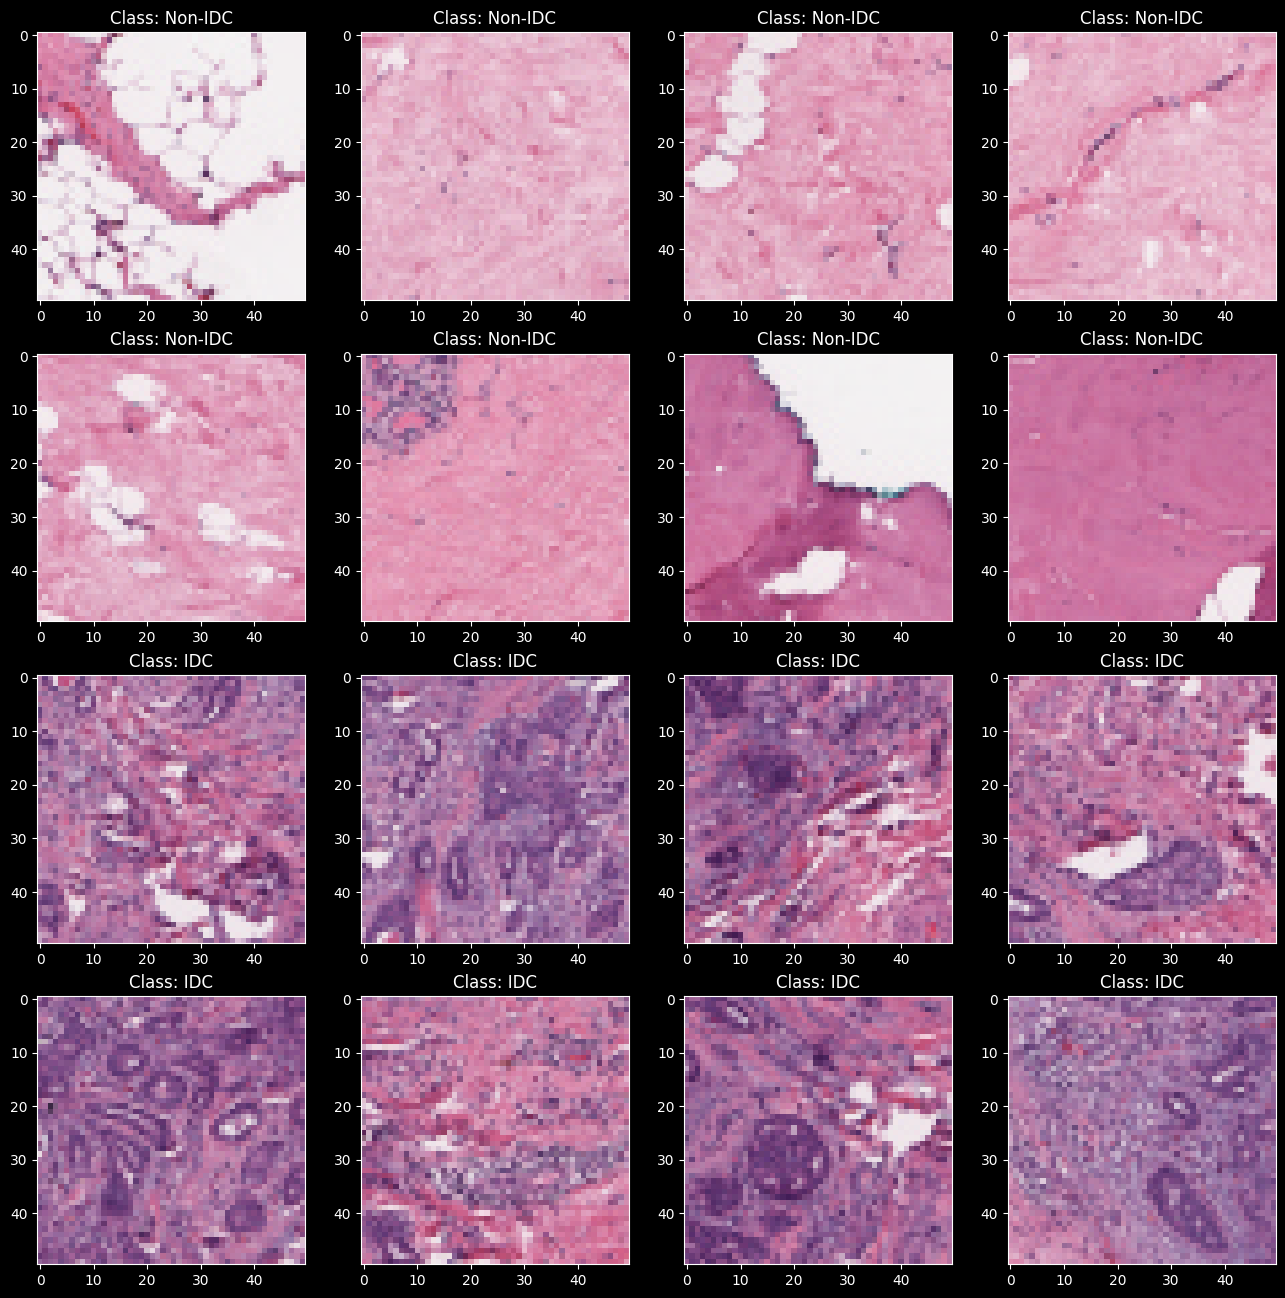

In [50]:
patient = "8867"
n_images = 16
# List the filenames for the non-IDC patches of the patient
non_idc_dir = os.listdir(f"data/{patient}/0")
# Randomly choose n_images/2 indices 
non_idc_idx = np.random.choice(range(len(non_idc_dir)), size=int(n_images/2), replace=False)
# And therefore choose n_images/2 patches randomly
non_idc_files = [non_idc_dir[index] for index in non_idc_idx] 
# Initialize a list of images
images = []
# Loop through all the files in this list
for file in non_idc_files:
    # Read in the image
    images.append(mpimg.imread(f"data/{patient}/0/{file}"))

# Apply the same method to the IDC patches of the patient
idc_dir = os.listdir(f"data/{patient}/1")
idc_idx = np.random.choice(range(len(idc_dir)), size=int(n_images/2), replace=False)
idc_files = [idc_dir[index] for index in idc_idx]
for file in idc_files:
    # Read in the image
    images.append(mpimg.imread(f"data/{patient}/1/{file}"))
    
# Visualize the data, along with their classifications
with plt.style.context("dark_background"):
    plt.figure(figsize=(16,16))
    for i, image in enumerate(images):
        # Show each of the images
        ax = plt.subplot(4, 4, i+1)
        ax.imshow(image)
        if i < 8:
            plt.title("Class: Non-IDC")
        else:
            plt.title("Class: IDC")

## Pre-processing

Given that the images are 50x50 pixels, we now preprocess the data to be used for training. To optimize the trade-off between memory usage, training speed, and final accuracy, we organize our images into batch sizes of 32. The batch size determines the number of images that should be fed forward through the network, with differences between the predicted output and actual output, the loss function, determining how the network should change to minimize these differences in the process of back-propagation. A single forward and backward propagation of information is done per batch.

Generally, smaller batch sizes will require less memory and will train a network faster, given that its state is updated more frequently. However, the training process is at the mercy of inherent stochasticity or randomness of the minimization method, whereas larger batch sizes will average out this randomness. A batch size of 32 is often a good choice to try initially.

We use a 70%-15%-15% training-validation-test split for the data. However, we must first manipulate the file directory of the data structure to group all the non-IDC and IDC images first.

In [ ]:
# Define a function which loops through all the images in directory and moves it to a new data folder which is organized 
# based on the presence of IDC
def data_organize(source_path, destination_path):
    # Loop through the patients
    for patient in os.listdir(source_path):
        # Loop through the IDC classifications
        for classification in os.listdir(f"{source_path}/{patient}"):
            # Loop through the image patches
            for image in os.listdir(f"{source_path}/{patient}/{classification}"):
                # Move the image to the organized folder, according to its classification
                shutil.move(f"{source_path}/{patient}/{classification}/{image}", f"{destination_path}/{classification}")

In [ ]:
# Organize the training and validation data
data_organize("data", "data_organized")
data_organize("val", "val_organized")

To further increase the performance of the model, we augment the training dataset by randomly flipping its orientation and rotating it. In doing so, we force the model to adapt and generalize its predictive capabilities. 

In [48]:
# Now the data is in a form that we can use the pre-processing helper functions from Keras
# The functions also progressively load in batches of data, so that we do not run into memory issues with large datasets.
image_size = (50,50)
batch_size = 32
# Prepare data augmentation configuration
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True)

# We do not want to do this with the validation dataset
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

# Create data generators for the training and validation datasets
train_generator = train_datagen.flow_from_directory(
    "data_organized",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    "val_organized",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

Found 240714 images belonging to 2 classes.
Found 34508 images belonging to 2 classes.


## Model Building

To create a machine learning model that is able to detect IDC from an image, we utilize _convolution layers_ in our neural network. Convolution layers have a number of desirable qualities in the analysis of images. They exhibit:

- local and therefore sparse interconnectivity, thereby lowering memory requirements and boosting statistical efficiency. Neurons in deeper layers exhibit very large receptive fields, despite not featuring the "dense" connectivity of more traditional neural networks.
- parameter sharing, such that each element or "weight" of a neuron is tied to others within the network. This parameter sharing leads to equivariance of translation for convolution layers, meaning that translation of the image will not affect the final output of the network.

The typical layer of a convolution neural network (CNN) involves applying a convolution kernel to the input, applying a nonlinear activation function of some kind, followed by a pooling operator, which summarizes the output in the local area spanned by the convolution kernel.

In the model we will create here, we include a few more additions. These involve:

- including batch normalization after convolution, which rescales the output such that the learning gradients remain relatively large so that continued model improvement is ensured;
- including layers that compute the depthwise separable convolution, so that features can be analyzed in the color channel dimensions;
- a dropout layer, whereby a neuron randomly has a weight of 0 in a particular learning iteration, to force other neurons in the network to generalize. This regularizes the model and prevent overfitting.

Usually, the deeper the network - that is, the more layers it features - the greater the accuracy when generalizing to test data, when the data itself is not a limiting factor in the creation of the model. However, recent academic literature suggests that there is an optimal depth beyond which the accuracy shows no appreciable increase. A curious workaround to this phenomenon is the inclusion of residual bypasses, whereby the output of a layer is separated from the network at a point and is later recombined further down the network. We implement this in our model below to increase its performance.

Note that this was not the first network architecture considered, but is included in this report because it generalized best to the data. Other attempts to create a deep learning model are briefly discussed in the appendix.

In [45]:
def make_model(input_shape):
    # Instantiate a Keras tensor
    inputs = tf.keras.Input(shape=input_shape)
    # Create a layer to normalize the RGB values of the image from 0 to 1
    x = tf.keras.layers.Rescaling(1.0/255)(inputs)
    # Loop the next two convolution macrolayers
    for filter_size in [32, 64]:
        # Add a 2D convolution layer
        x = tf.keras.layers.Conv2D(filter_size, 3, strides=2, padding='valid')(x)
        # Apply batch normalization
        x = tf.keras.layers.BatchNormalization()(x)
        # Use rectified linear units as the activation
        x = tf.keras.layers.Activation('relu')(x)
    # Set aside a residual to create a bypass in the neural network
    previous_activation = x 
    # Loop the next two depthwise separable convolution macrolayers
    for filter_size in [128, 256]:
        # Add a 2D depthwise separable convolution layer
        x = tf.keras.layers.SeparableConv2D(filter_size, 3, strides=2, padding='same')(x)
        # Apply batch normalization
        x = tf.keras.layers.BatchNormalization()(x)
        # Use rectified linear units as the activation
        x = tf.keras.layers.Activation('relu')(x)
        # Project the residual so that they can be added later
        residual = tf.keras.layers.Conv2D(filter_size, 3, strides=2, padding='same')(previous_activation)
        # Apply a max pooling layer
        residual = tf.keras.layers.MaxPooling2D(filter_size, strides=1, padding='same')(residual)
        # Add the residual to the current layer
        x = tf.keras.layers.add([x, residual])
        # Set aside the residual again
        previous_activation = x
    # Use a global average pooling layer to collapse the tensor that leave only the depth dimension
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # Include a dropout layer with 50% dropout
    x = tf.keras.layers.Dropout(0.5)(x)
    # Finish off the model with a dense layer connecting to a single output, featuring a sigmoid activation, 
    # which will return either a 0 or 1, inline with the binary classification problem of interest
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    # Return the final model
    return tf.keras.Model(inputs, output)

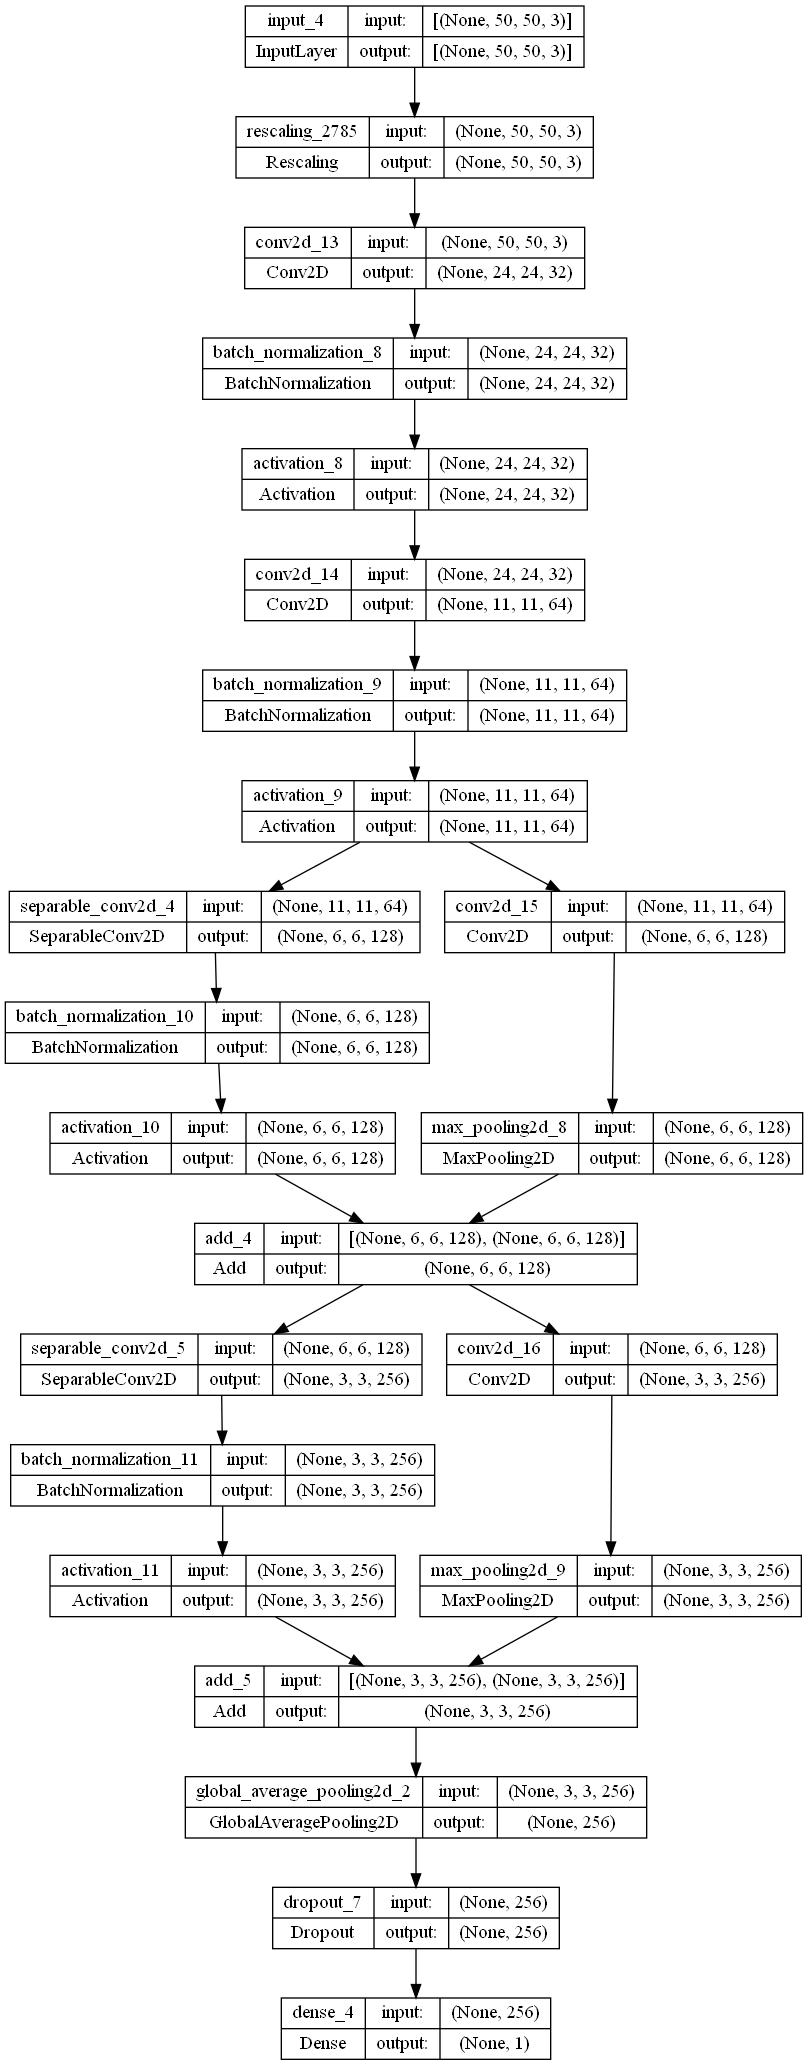

In [46]:
# Generate the model from the function above
# Note that we need to include the 3 RGB chanels in input_shape
model = make_model(input_shape=image_size + (3,))
# Plot a flow diagram of the neural network
tf.keras.utils.plot_model(model, show_shapes=True)

## Training the Model

With the model constructed, we now begin training it with data. Initially, we will use an Adams optimizer, a particular example of the stochastic gradient descent method that features adaptive stepping, which is a generically good choice for machine learning problems, and suppose a loss function that is described by the binary cross-entropy, given that there are only two possible outputs for the classification.

We train the model on a GPU, which runs approximately 30 times quicker than on the CPU, and we monitor the progress of training via TensorBoard.

In [7]:
# Check whether the GPU is accessible by TensorFlow as this will speed up training significantly
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [47]:
# Define the number of epochs to train the model
epochs = 15
# Force callbacks to save the state of the trained model if a crash were to occur.
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at_4_{epoch}.h5")]
# Initiate logs and callback to Tensorboard to monitor training progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs4", histogram_freq=1)
# Compile the model, with the optimizer and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [49]:
history_4 = model.fit(train_generator, callbacks=[tensorboard_callback, callbacks], 
                    validation_data=validation_generator, epochs = epochs, batch_size=batch_size)

Epoch 1/15
7523/7523 [==============================] - 508s 67ms/step - loss: 0.3623 - accuracy: 0.8466 - val_loss: 0.3500 - val_accuracy: 0.8507
Epoch 2/15
7523/7523 [==============================] - 505s 67ms/step - loss: 0.3240 - accuracy: 0.8613 - val_loss: 0.3367 - val_accuracy: 0.8559
Epoch 3/15
7523/7523 [==============================] - 518s 69ms/step - loss: 0.3109 - accuracy: 0.8671 - val_loss: 0.9239 - val_accuracy: 0.5771
Epoch 4/15
7523/7523 [==============================] - 499s 66ms/step - loss: 0.3034 - accuracy: 0.8706 - val_loss: 0.3386 - val_accuracy: 0.8550
Epoch 5/15
7523/7523 [==============================] - 513s 68ms/step - loss: 0.2987 - accuracy: 0.8729 - val_loss: 0.3214 - val_accuracy: 0.8610
Epoch 6/15
7523/7523 [==============================] - 503s 67ms/step - loss: 0.2937 - accuracy: 0.8758 - val_loss: 0.4155 - val_accuracy: 0.8191
Epoch 7/15
7523/7523 [==============================] - 500s 66ms/step - loss: 0.2894 - accuracy: 0.8769 - val_loss: 0

In [65]:
# Define a function to plot the accuracy and cross-entropy of training
def history_plot(history):
    with plt.style.context("dark_background"):
        fig, ax = plt.subplots(ncols=2, figsize=(16,6))
        ax[0].plot(history.history['accuracy'], lw=2, color='red', label='Training')
        ax[0].plot(history.history['val_accuracy'], lw=2, color='cyan', label='Validation')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Accuracy')
        ax[0].legend()
        ax[1].plot(history.history['loss'], lw=2, color='red', label='Training Loss')
        ax[1].plot(history.history['val_loss'], lw=2, color='cyan', label='Validation Loss')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Cross-Entropy (nbits)')
        ax[1].legend()

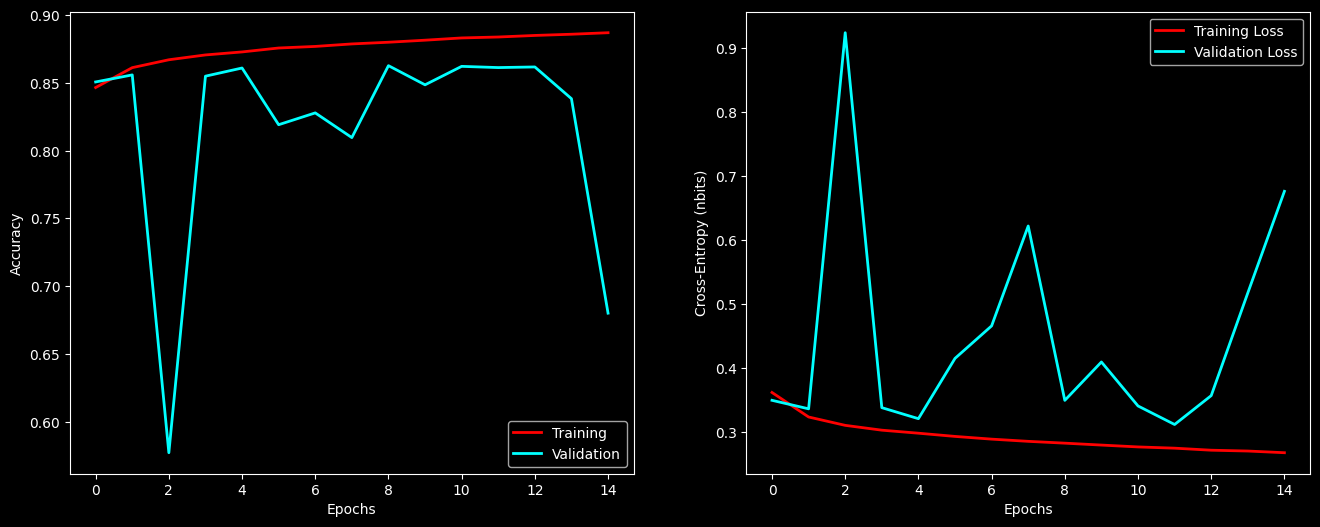

In [66]:
# Plot the training history
history_plot(history_4)

Despite the stochastic fluctuations in the validation accuracy and loss, we conclude that there is not appreciable overfitting, given that the mean accuracy of the training and validation datasets are close to one another, nor underfitting, as both accuracies approach >80%.

However, we want to mitigate the randomness to obtain a better result. Therefore, we repeat training, however, this time we increase the batch size to 75, so that the descent in the high dimensional space of the network weights is not perturbed so strongly by stochasticity, and lower the learning rate to fine-tune the model and ease it into a minimizing configuration.

In [50]:
# Increase the batch size to 75 and preprocess the data again
batch_size = 75
# prepare data augmentation configuration
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    "data_organized",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    "test_organized",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

Found 240714 images belonging to 2 classes.
Found 34508 images belonging to 2 classes.


In [51]:
# Train the model again, but on fewer epochs
epochs = 10
# Force callbacks to save the state of the trained model if a crash were to occur.
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at_5_{epoch}.h5")]
# Initiate logs and callback to Tensorboard to monitor training progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs5", histogram_freq=1)
# Compile the model, with the optimizer and loss function, also lower the learning rate.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [52]:
history_5 = model.fit(train_generator, callbacks=[tensorboard_callback, callbacks], 
                    validation_data=validation_generator, epochs = epochs, batch_size=batch_size)

Epoch 1/10
3210/3210 [==============================] - 484s 150ms/step - loss: 0.2584 - accuracy: 0.8912 - val_loss: 0.3653 - val_accuracy: 0.8392
Epoch 2/10
3210/3210 [==============================] - 483s 151ms/step - loss: 0.2564 - accuracy: 0.8923 - val_loss: 0.3329 - val_accuracy: 0.8679
Epoch 3/10
3210/3210 [==============================] - 475s 148ms/step - loss: 0.2546 - accuracy: 0.8932 - val_loss: 0.3155 - val_accuracy: 0.8734
Epoch 4/10
3210/3210 [==============================] - 476s 148ms/step - loss: 0.2538 - accuracy: 0.8938 - val_loss: 0.3100 - val_accuracy: 0.8673
Epoch 5/10
3210/3210 [==============================] - 474s 147ms/step - loss: 0.2529 - accuracy: 0.8934 - val_loss: 0.3188 - val_accuracy: 0.8725
Epoch 6/10
3210/3210 [==============================] - 475s 148ms/step - loss: 0.2523 - accuracy: 0.8942 - val_loss: 0.3003 - val_accuracy: 0.8748
Epoch 7/10
3210/3210 [==============================] - 474s 148ms/step - loss: 0.2510 - accuracy: 0.8950 - val_

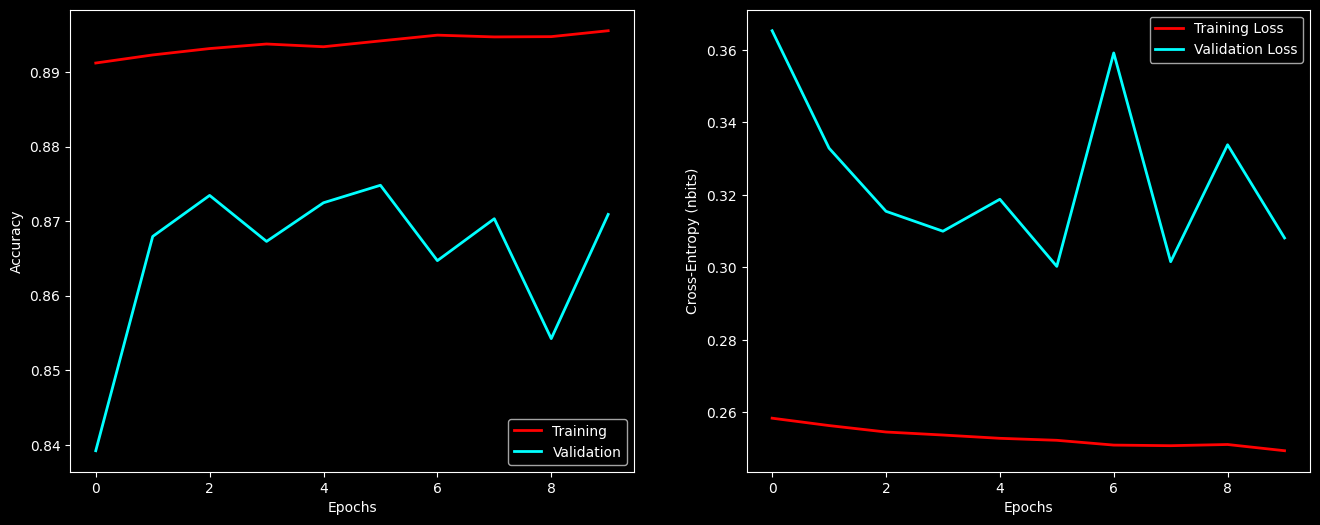

In [67]:
# Plot the training results
history_plot(history_5)

## Benchmarking on Test Data

The above is a very nice result, as we have hit a 87 % accuracy in the validation dataset as well as an acceptable cross-entropy, being approximately 0.30, which quantifies the uncertainty in the neural network's prediction. We proceed with benchmarking on the test set and compare our results to those by Cruz-Roa et al.

In [ ]:
# Organize the test data directory
data_organize("test", "test_organized")

In [72]:
# Using the model, generate predictions from the test data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
# We do not shuffle the test data because it will be easier to label.
test_data = test_datagen.flow_from_directory("test_organized", target_size=image_size, batch_size=batch_size, shuffle=False)
predictions = model.predict(test_data, batch_size=batch_size)
# Here are the actual labels of the data
labels = [0]*23360 + [1]*11148

Found 34508 images belonging to 2 classes.
461/461 [==============================] - 13s 28ms/step


In [73]:
# Run a classification report on the data
# Note that the predictions have to be rounded to either 0 or 1 in order to compare with the true labels
print(classification_report(np.array(labels), np.round(predictions).ravel()))
conf_matrix = confusion_matrix(np.array(labels), np.round(predictions).ravel())
se = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
sp = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
print(f"Total sensitivity: {se*100:.4f} %")
print(f"Total specificity: {sp*100:.4f} %")
print(f"Final balanced accuracy is {0.5*(se+sp)*100:.4f} %")

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     23360
           1       0.84      0.74      0.79     11148

    accuracy                           0.87     34508
   macro avg       0.86      0.84      0.85     34508
weighted avg       0.87      0.87      0.87     34508

Total sensitivity: 88.1411 %
Total specificity: 84.4113 %
Final balanced accuracy is 86.2762 %


As a reminder, the performance metrics to beat were:

- Precision (Pr): 65.40%
- Recall (Re)/Sensitivity: 79.60%
- Specificity: 88.86%
- F1 (defined as $2\cdot\text{Pr}\cdot\text{Re}/(\text{Pr}+\text{Re})$): 71.80%
- Balanced Accuracy (defined as the average of the sensitivity and specificity): 84.23%

Our model does remarkably well, exceeding in every metric (Precision: 87%, Recall: 87%, F1: 87%, Balanced Accuracy: 86.2762%), barring specificity (84.4113%). In particular, our model is significantly more sensitive and precise, meaning that it is the superior model in detecting IDC-positive patches, and, out of the positives that it does detect, a larger proportion are relevant (i.e. they are not false positives). However, it is slightly more likely to return false positives compared to the model of Cruz-Roa et al.

Given that the original intention of training a deep learning model was to automate the prediction of IDC prevalence in breast tissue, we use the model we have created to generate IDC probabilities on every image patch associated with a specific patient and construct a probability map on the whole slide sample below.

In [98]:
def whole_slide_plot(patient):
    # Start the timer 
    start_time = default_timer()
    # Convert the patient number into a string
    patient = str(patient)
    # Initialize lists storing the x and y values of the image patch as well as its classification and associated prediction
    x = []
    y = []
    label = []
    predictions = []
    # Loop through the IDC classifications
    for i in os.listdir("test_organized/"):
        # Loop through each file in the list
        for image_path in os.listdir(f"test_organized/{i}"):
            # Split the filename by the under score and check whether the first entry is the specified patient's
            if image_path.split('_')[0] == patient:
                # Read in the corresponding image
                image = tf.keras.preprocessing.image.load_img(f"test_organized/{i}/{image_path}")
                # Convert it into a batched array
                image_array = tf.keras.preprocessing.image.img_to_array(image)
                # Expand its dimensions to fit into the model input
                image_array = tf.expand_dims(image_array, 0)
                # Run the image through a rescaling layer before generating a prediction
                predictions.append(model.predict(image_array, verbose=0)[0][0])
                # Store the x and y coordinates and the true label
                x.append(int(image_path.split('x')[-1].split('_')[0]))
                y.append(int(image_path.split('y')[-1].split('_')[0]))
                label.append(int(i))
    # Print the results
    print(f"Predicted invasive ductal carcinoma presence on {len(predictions)} image patches in {default_timer()-start_time:.2f} s. Plotting whole slide sample.")
    # Plot the true and predicted whole-slide samples side by side for comparison.
    with plt.style.context("dark_background"):
        fig, ax = plt.subplots(ncols=2, figsize=(16,8), sharey=True)
        # Plot the true whole-slide sample
        ax[0].scatter(x,y, c=label, cmap='cool', alpha=0.5, marker='s')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[0].set_title(f'Actual IDC Aggression for Patient {patient}')
        ax[1].scatter(x,y, c=predictions, cmap='rainbow', alpha=0.5, marker='s')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[1].set_title(f'Predicted IDC Aggression for Patient {patient}')
    return x, y, label, predictions

Predicted invasive ductal carcinoma presence on 917 image patches in 33.23 s. Plotting whole slide sample.


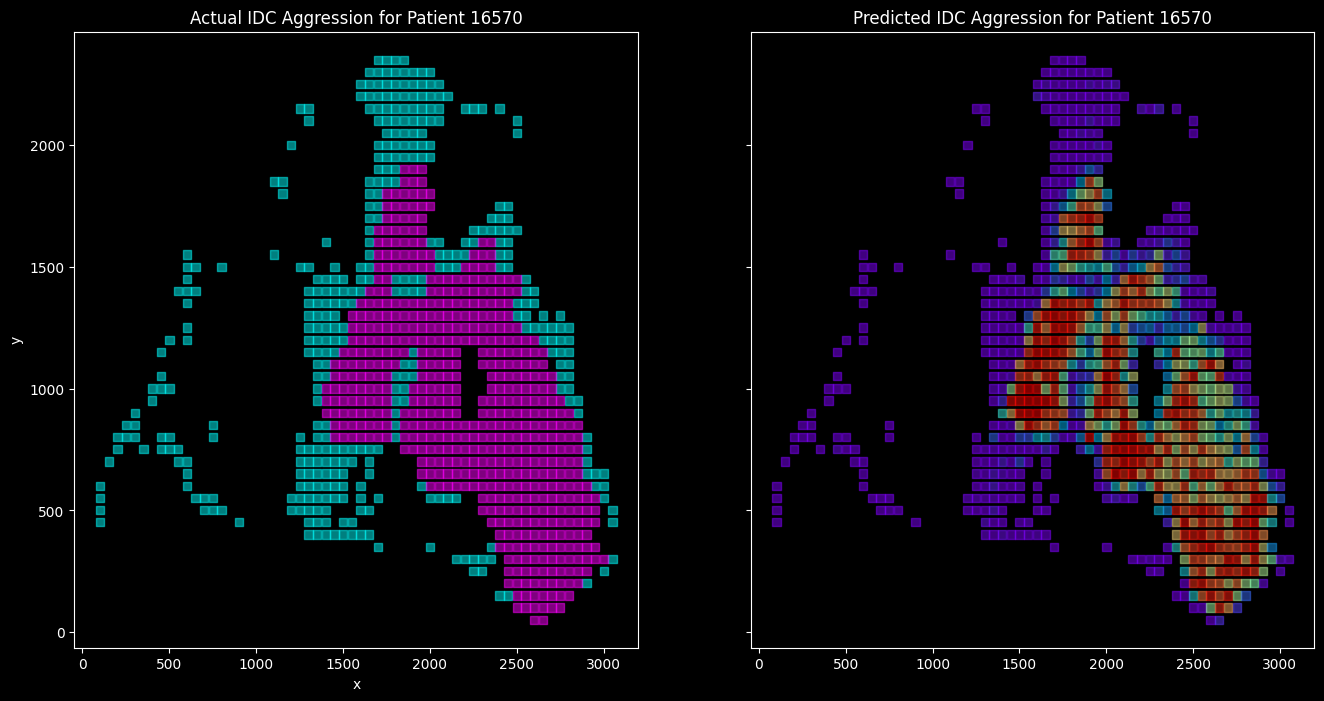

In [99]:
x, y, label, predictions = whole_slide_plot(16570)

Predicted invasive ductal carcinoma presence on 1291 image patches in 48.27 s. Plotting whole slide sample.


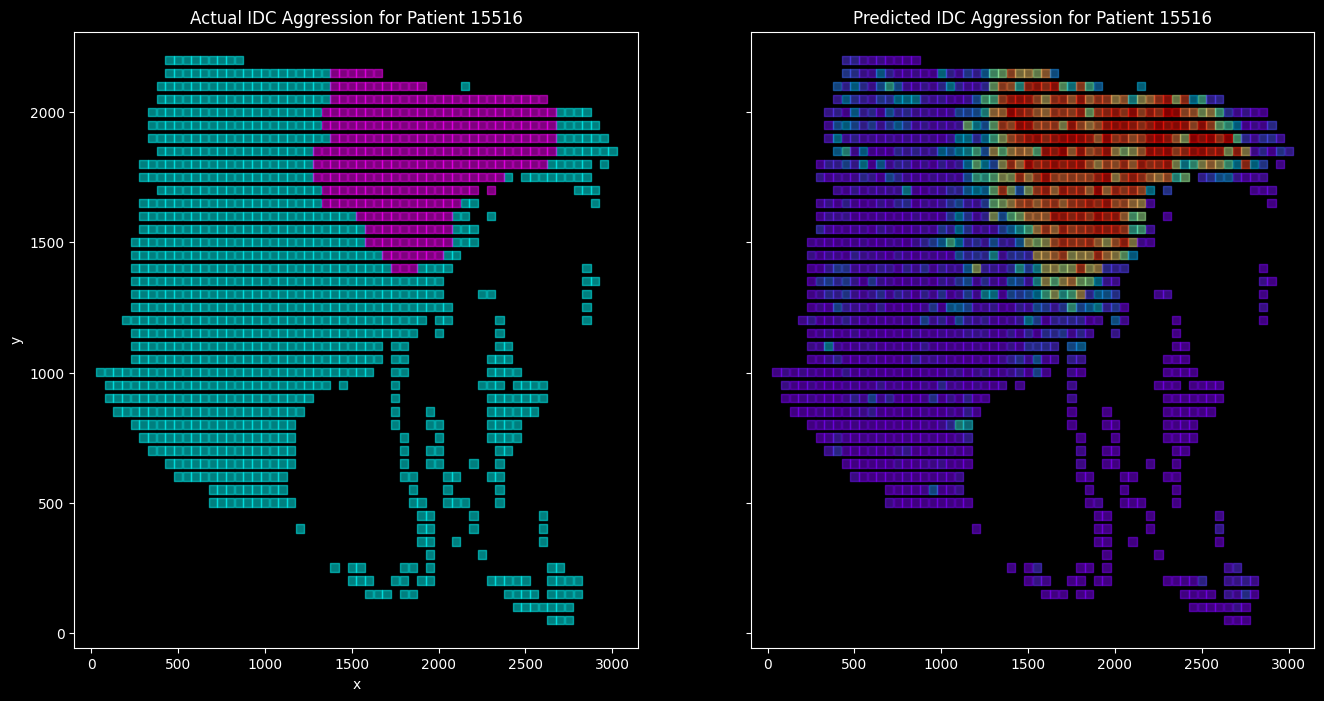

In [100]:
x, y, label, predictions = whole_slide_plot(15516)

Predicted invasive ductal carcinoma presence on 1163 image patches in 43.03 s. Plotting whole slide sample.


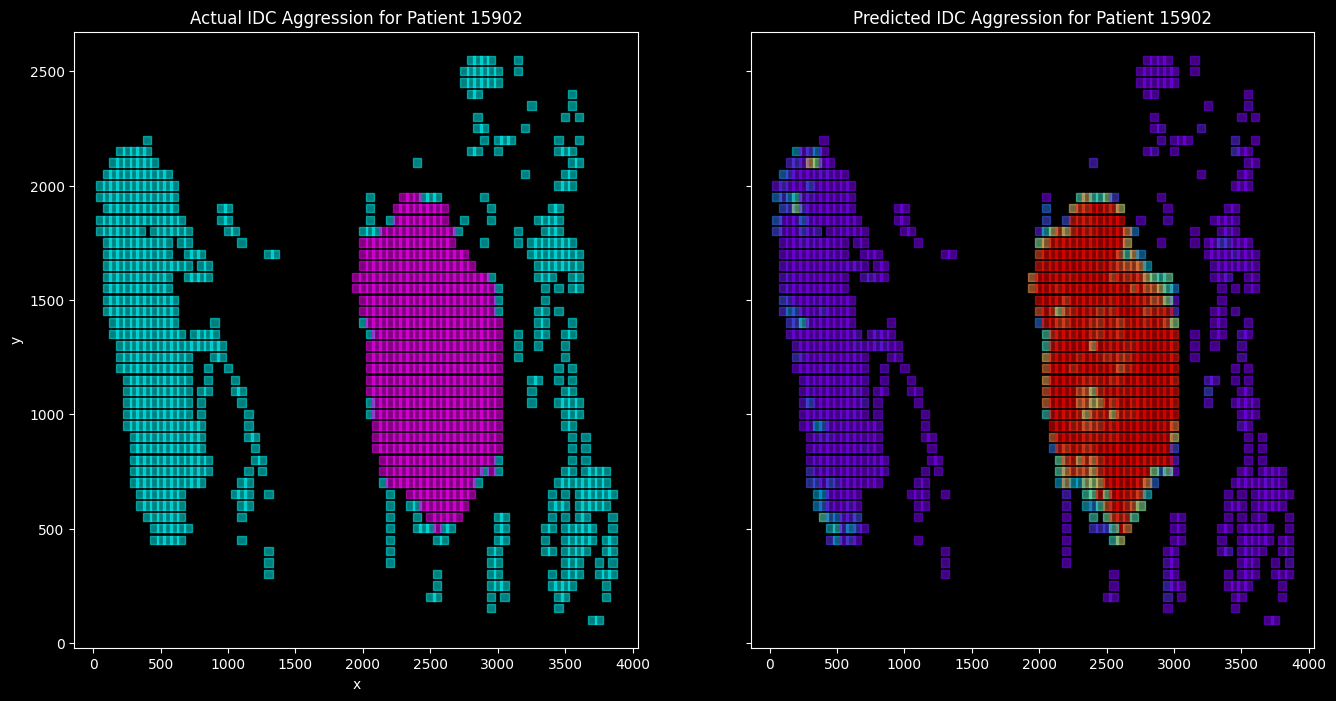

In [101]:
x, y, label, predictions = whole_slide_plot(15902)

## Conclusion

We have created a neural network that has generalized to classifying IDC better than the work of Cruz-Roa et al. However, the model could be improved, namely, in regards in the mitigation of false positives, as seen in the predicted IDC prevalences of patient 15516 and 15902. 

One could attempt to remedy this by further training, potentially with more radical data augmentation, or including further regularization in the network architecture itself (i.e. more dropout layers, or L1/L2 regularization). However, a natural question to ask is what pattern the model is drawing to differentiate between cancerous and non-cancerous image patches, or whether there is a way that we can preprocess the image by removing irrelevant data, such that the neural network can more easily find a pattern. Consulting a specialist would provide additional insight on the features that lead to a positive or negative classification. With this in mind, the dataset can be manipulated to emphasize these features, whether they be the luminosity, texture, or RGB information associated with the image, and therefore make finding a pattern easier for the neural network.

We illustrate this briefly below by masking the fat tissue in the image and extracting the red channel information, given that IDC positive patches are largely more purple.

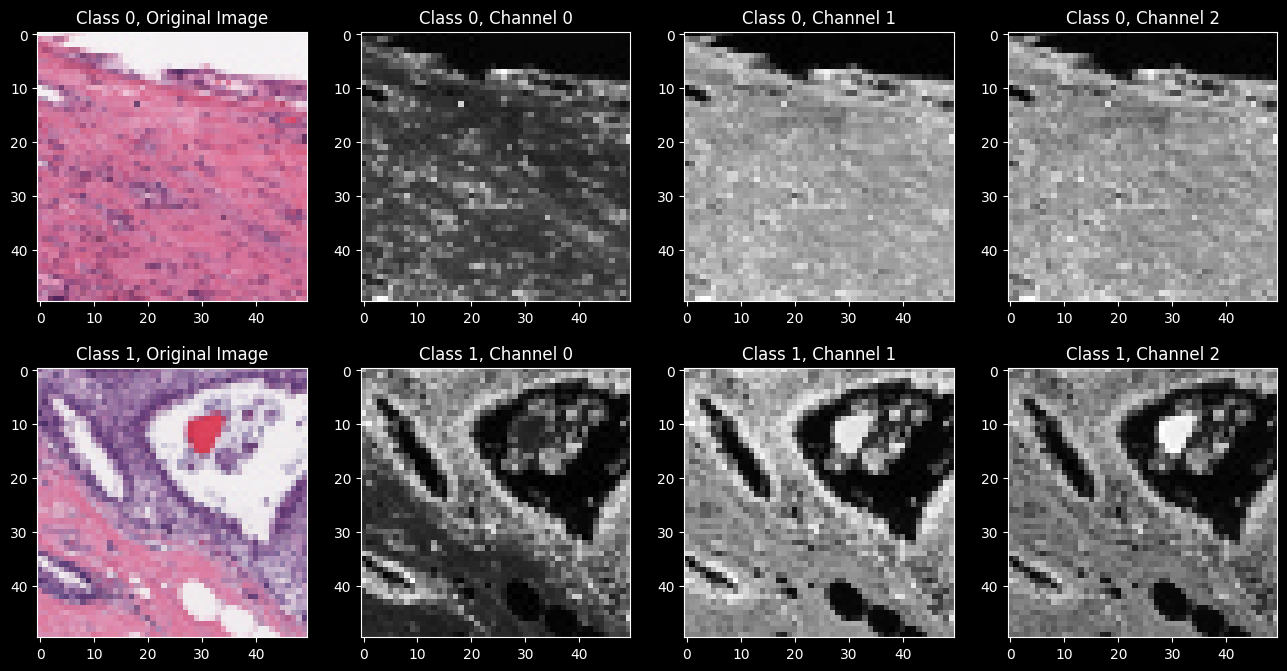

In [104]:
images = []
# Read in a non-IDC image
images.append(mpimg.imread("data_organized/0/8863_idx5_x251_y1301_class0.png"))
# Read in aa IDC image
images.append(mpimg.imread("data_organized/1/14211_idx5_x2601_y1451_class1.png"))
   
# Visualize the data, along with their classifications
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16,8))
    for i in range(len(images)):
        ax[i,0].imshow(images[i])
        ax[i,0].set_title(f"Class {i}, Original Image")
        for j in range(3):
            ax[i,j+1].imshow(images[i][:,:,j], cmap='binary')
            ax[i,j+1].set_title(f"Class {i}, Channel {j}")

We observe that IDC positive tissue appears more purple than the healthy pink of IDC negative tissue - this is most evident in the red channel (i.e. channel 0) - whereas, using the green channel (i.e. channel 1), we can mask the fat tissue (white in the original image, black in channel 1). Combining these together yields a simpler image for the neural network to train and therefore learn patterns from.

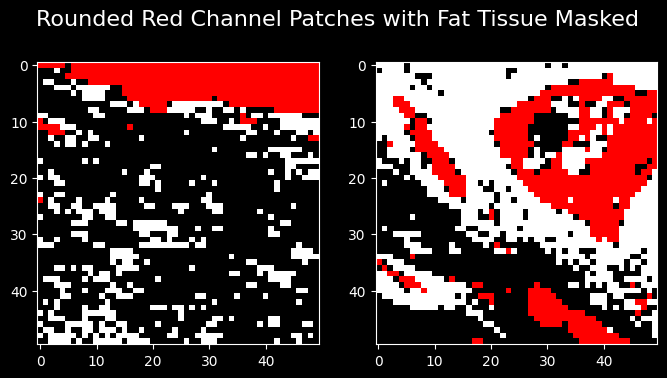

In [109]:
# Create masks to mask out the fat tissue
g = 2
green_mask = [1-np.floor((1/g)*np.round(g*images[i][:,:,1])) for i in range(len(images))]
cmap = plt.cm.get_cmap("binary").copy()
cmap.set_bad(color='r')
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    for i in range(len(images)):
        image = np.copy(images[i][:,:,0])
        image[~green_mask[i].astype(bool)] = np.nan
        ax[i].imshow(np.round(0.7*image), cmap=cmap)
    fig.suptitle("Rounded Red Channel Patches with Fat Tissue Masked", fontsize=16)

## Appendix: Other Network Architectures Considered

We briefly discuss some of the other attempted network architectures that were created and trained and why they were not chosen as the final model above. 

### Single Chain Network

The first model did not feature a residual bypass, but rather was a single continuous chain from the input layer to the output layer. This is a good initial attempt, as the model is simple and therefore quicker to train. Whilst the model yields acceptable accuracies on both training and validation datasets, their corresponding cross-entropy is high. A model with high accuracy and high cross-entropy correctly guesses the classification of an image, but by a slim margin (say, a probability of 0.55 to 0.45). This is undesirable for classification problems because it implies that the neural network is not robust to noise in its input data. The perturbations produced by such noise might be such that the model's output flips and therefore predicts the wrong result.

In [24]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = 'relu'))

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0

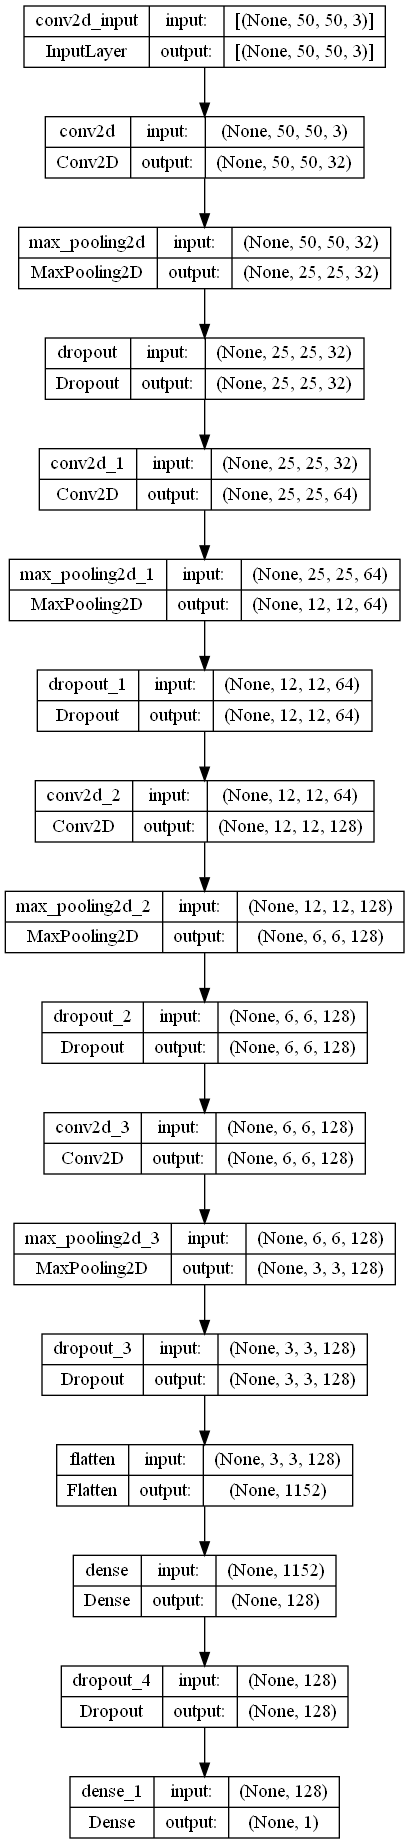

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [32]:
# Force callbacks to save the state of the trained model if a crash were to occur.
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at_3_{epoch}.h5")]
# Initiate logs and callback to Tensorboard to monitor training progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs3", histogram_freq=1)
Adam = Adam(learning_rate = 0.00005)
model.compile(loss = 'binary_crossentropy', optimizer = Adam, metrics = ['accuracy'])

# This was the result after 3 training fits and lowering the corresponding learning rate to fine-tune the model.
history_3 = model.fit(train_generator, callbacks=[tensorboard_callback, callbacks], 
                    validation_data=validation_generator, epochs = 10, batch_size=batch_size)

Epoch 1/10
7523/7523 [==============================] - 254s 34ms/step - loss: 0.3083 - accuracy: 0.8710 - val_loss: 0.3819 - val_accuracy: 0.8319
Epoch 2/10
7523/7523 [==============================] - 256s 34ms/step - loss: 0.3068 - accuracy: 0.8712 - val_loss: 0.3684 - val_accuracy: 0.8378
Epoch 3/10
7523/7523 [==============================] - 257s 34ms/step - loss: 0.3068 - accuracy: 0.8708 - val_loss: 0.3741 - val_accuracy: 0.8358
Epoch 4/10
7523/7523 [==============================] - 256s 34ms/step - loss: 0.3064 - accuracy: 0.8715 - val_loss: 0.3785 - val_accuracy: 0.8327
Epoch 5/10
7523/7523 [==============================] - 260s 35ms/step - loss: 0.3058 - accuracy: 0.8713 - val_loss: 0.3920 - val_accuracy: 0.8285
Epoch 6/10
7523/7523 [==============================] - 257s 34ms/step - loss: 0.3129 - accuracy: 0.8714 - val_loss: 0.3752 - val_accuracy: 0.8361
Epoch 7/10
7523/7523 [==============================] - 259s 34ms/step - loss: 0.3059 - accuracy: 0.8715 - val_loss: 0

### Transfer Learning with VGG16

Another option considered was utilizing a large convolution neural network, that had been pre-trained, as the image recognition backbone of our neural network. This has the benefit of being quick to implement, as much fewer network parameters need to be trained. In practice, we trained a dense classification layer, using the outputs of the image recognition backbone as the inputs, before fine-tuning the weights of this same classification layer and the last few convolution blocks in an attempt to generalize the model to the problem of discerning IDC in image patches.

Despite using a far more thoroughly trained image-recognition network and a pre-trained classification layer, the model still exhibits high cross-entropy in the validation dataset. This result could be for two reasons: First, the image recognition backbone had been trained on images of dimensions 224x224x3, whereas our images are 50x50x3, so that the reshaping of the input images could introduce artefacts which the model misclassifies. 

Furthermore, the backbone's pretrained weights derived from learning on ImageNet data, which is geared towards object recognition (i.e. dogs, cats, cars, horses) rather than medical imagery. As a consequence, the model is likely not trained to recognize features most pertinent in breast cancer classification.

In [218]:
# Build the VGG16 network
model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
print("Done!")    

58889256/58889256 [==============================] - 18s 0us/step
Done!


In [235]:
# Create a data generator for the training data
generator = datagen.flow_from_directory("data_organized/",
                                        target_size=image_size,
                                        batch_size=32,
                                        class_mode=None,
                                        shuffle=False)
classifier_train = model.predict(generator, 242577//batch_size)
np.save(open('bottleneck_features_train.npy', 'wb'), classifier_train)

Found 242577 images belonging to 2 classes.
7581/7581 [==============================] - 105s 14ms/step


In [229]:
# Create a data generator for the validation data
generator = datagen.flow_from_directory("val_organized/",
                                        target_size=image_size,
                                        batch_size=32,
                                        class_mode=None,
                                        shuffle=False)
classifier_test = model.predict(generator, 34947//batch_size)
np.save(open('bottleneck_features_test.npy', 'wb'), classifier_test)

Found 34947 images belonging to 2 classes.
1093/1093 [==============================] - 102s 93ms/step


In [300]:
# Load in the training and validation data, which are outputs from the image-recognition backbone,
# as inputs for the dense classification layer.
train_data = np.load('classifier_train.npy')
train_labels = np.array([0]*174939 + [1]*67638)
validation_data = np.load('classifier_test.npy')
validation_labels = np.array([0]*23799 + [1]*11148)

In [312]:
# Create a quick model
quick_model = tf.keras.models.Sequential()
quick_model.add(tf.keras.layers.Flatten(input_shape=train_data.shape[1:]))
quick_model.add(tf.keras.layers.Dense(1024, activation='relu', activity_regularizer=tf.keras.regularizers.l1_l2(0.01)))
quick_model.add(tf.keras.layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l1_l2(0.01)))
quick_model.add(tf.keras.layers.Dropout(0.5))
quick_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

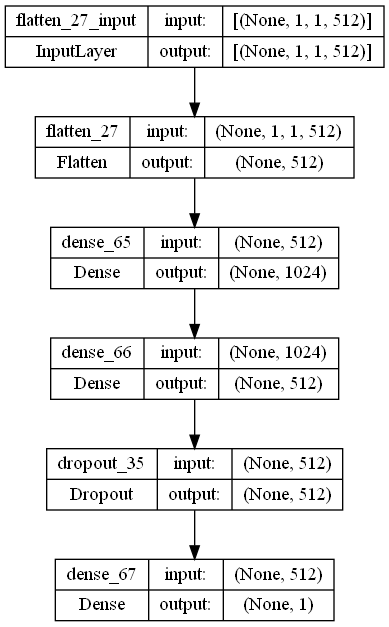

In [313]:
tf.keras.utils.plot_model(quick_model, show_shapes=True)

In [314]:
# Compile the model
quick_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [315]:
# Fit the model - look at the speed of training!
history = quick_model.fit(train_data, train_labels, epochs=20, batch_size=batch_size, validation_data=(validation_data, validation_labels))

Epoch 1/20
4852/4852 [==============================] - 20s 4ms/step - loss: 0.4532 - accuracy: 0.8219 - val_loss: 0.4567 - val_accuracy: 0.8102
Epoch 2/20
4852/4852 [==============================] - 19s 4ms/step - loss: 0.4221 - accuracy: 0.8288 - val_loss: 0.4208 - val_accuracy: 0.8257
Epoch 3/20
4852/4852 [==============================] - 20s 4ms/step - loss: 0.4171 - accuracy: 0.8292 - val_loss: 0.4201 - val_accuracy: 0.8257
Epoch 4/20
4852/4852 [==============================] - 19s 4ms/step - loss: 0.4155 - accuracy: 0.8301 - val_loss: 0.4114 - val_accuracy: 0.8284
Epoch 5/20
4852/4852 [==============================] - 20s 4ms/step - loss: 0.4135 - accuracy: 0.8299 - val_loss: 0.4255 - val_accuracy: 0.8189
Epoch 6/20
4852/4852 [==============================] - 19s 4ms/step - loss: 0.4133 - accuracy: 0.8302 - val_loss: 0.4262 - val_accuracy: 0.8213
Epoch 7/20
4852/4852 [==============================] - 20s 4ms/step - loss: 0.4136 - accuracy: 0.8301 - val_loss: 0.4126 - val_ac

In [273]:
# Save the weights
quick_model.save_weights("quick_model_weights.h5")

With the classification layer pre-trained, we now combine it with the image recognition backbone (i.e. VGG16 network), and only make the latter's last convolution block trainable to fine-tune the network to the problem of breast cancer classification.

In [292]:
# Build the VGG16 network
model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
# Combine the VGG16 model with the trained classifier
top_model = tf.keras.models.Sequential()
top_model.add(tf.keras.layers.GlobalAveragePooling2D(input_shape=model.output_shape[1:]))
top_model.add(tf.keras.layers.Dense(1024, activation='relu'))
top_model.add(tf.keras.layers.Dense(512, activation='relu'))
top_model.add(tf.keras.layers.Dropout(0.5))
top_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
top_model.load_weights("quick_model_weights.h5")
combined_model = tf.keras.models.Model(inputs=model.input, outputs=top_model(model.output))

In [293]:
# Set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in combined_model.layers[:25]:
    layer.trainable = False

In [298]:
# Compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
combined_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

# We can now employ the use of data augmentation to further generalize the neural network
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    "data_organized",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    "val_organized",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

Found 242577 images belonging to 2 classes.
Found 34947 images belonging to 2 classes.


In [299]:
# fine-tune the model
combined_model.fit(
    train_generator,
    batch_size=32,
    epochs=20,
    validation_data=validation_generator)

Epoch 1/20
4852/4852 [==============================] - 281s 58ms/step - loss: 0.3749 - accuracy: 0.8400 - val_loss: 0.4233 - val_accuracy: 0.8216
Epoch 2/20
4852/4852 [==============================] - 269s 55ms/step - loss: 0.3736 - accuracy: 0.8402 - val_loss: 0.4233 - val_accuracy: 0.8216
Epoch 3/20
4852/4852 [==============================] - 273s 56ms/step - loss: 0.3751 - accuracy: 0.8401 - val_loss: 0.4233 - val_accuracy: 0.8216
Epoch 4/20
 118/4852 [..............................] - ETA: 4:18 - loss: 0.3616 - accuracy: 0.8514

KeyboardInterrupt: 